In [1]:
import xarray as xr
from dask.distributed import Client
import time
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import sys
import gc
import numpy as np
sys.setrecursionlimit(100000)

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
from matplotlib import path
import scipy.io as sio
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import seaborn as sns
import cmaps
import seapy
from scipy.spatial import KDTree
import dask

In [2]:
#define your root paths
myobsroot = '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/'
mynlroot = '/Volumes/WD_3/outputs_SCORRECTION/'
#define your workspace 
nl_workspace = 'outputs_201205/'
obs_workspace = ''
obs_file='geopolar_sst_2012to14_offshore.nc'
nl_files = "ocean_ecs_his_00*.nc"

In [3]:
#define your target data duration

start_date = '2012-05-01-12H'
end_date = '2014-05-11-12H'

start_datetime = dt.datetime.strptime(start_date,"%Y-%m-%d-%HH")
end_datetime = dt.datetime.strptime(end_date,"%Y-%m-%d-%HH")
data_len = (end_datetime-start_datetime).days+1 

#define your target variable
obs_var = 6
# 2d situation
# model_var = 'temp_sur' 
#3d situation
model_var = 'temp'

# setting chunk size
x_chunk = int(262/2)
y_chunk = int(362/2)
z_chunk = 10

print('''duration to be validated: from %s to %s, total of %i days.
         target obs variable: %s
         target model variable: %s'''
      %(start_date,end_date,data_len,obs_var,model_var))



duration to be validated: from 2012-05-01-12H to 2014-05-11-12H, total of 741 days.
         target obs variable: 6
         target model variable: temp


In [4]:
# loading observation data
Obs_ds = xr.open_dataset(myobsroot+obs_workspace+obs_file,
                           engine='netcdf4',
                           # chunks={'longitude':260,'latitude':210},
                         
                           )

In [5]:
# extracting cruise observation data with specific time range 
start_obstime = (start_datetime - dt.datetime(1970,1,1)).total_seconds()/3600/24
end_obstime = (end_datetime - dt.datetime(1970,1,1)).total_seconds()/3600/24

this_range = np.where( 
                                (Obs_ds.obs_time.data >= start_obstime) &
                                (Obs_ds.obs_time.data <= end_obstime)  &
                                (Obs_ds.obs_provenance == 355)&
                                (Obs_ds.obs_type == obs_var)
                        )


Obs_ds = Obs_ds.isel(datum=this_range[0]).copy()
timestamp = [ dt.timedelta(itime)+dt.datetime(1970,1,1) for itime in Obs_ds.obs_time.data]


In [6]:
Obs_ds = Obs_ds.assign_coords(datum=timestamp)

In [7]:
# loading forward sst
start = time.time()
nl_ds = xr.open_mfdataset(mynlroot+nl_workspace+nl_files,
                                      engine='netcdf4',coords='minimal',
                                      parallel=True,
                                      # chunks={'eta_rho':y_chunk,'xi_rho':x_chunk,
                                      #      's_rho':z_chunk, # only 3d needed
                                      #      'eta_u':y_chunk,'xi_u':x_chunk,\
                                      #      'eta_v':y_chunk,'xi_v':x_chunk,\
                                      #      'eta_psi':y_chunk,'xi_psi':x_chunk,},
                                       )#.chunk(dict(ocean_time=-1))
end = time.time()
print('loading costing %f min'%((end-start)/60))


loading costing 3.692296 min


In [8]:
# extracting forward sst with specific time range 
# for forward there is no qck file ,so the model var has only 'temp'
# further we only want the surface data, so the s_rho = -1
nl_data = nl_ds[model_var].sel(ocean_time=slice(start_date,end_date)).isel(s_rho=-1)
# always drop the initial time of posterior since there is a jump
nl_data = nl_data.drop_duplicates(dim='ocean_time',keep='last')
# fwd_data


In [9]:
#calculate the daily mean 
start = time.time()
nl_dailymean = dask.compute(nl_data.resample(ocean_time='1d').mean())
# nl_dailymean = nl_dailymean.assign_coords({'ocean_time':Obs_modgrd.ocean_time.data})
end = time.time()
print('calculating costing %f min'%((end-start)/60))



calculating costing 4.581838 min


In [10]:
my_sst_color = sio.loadmat('/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/'+
                           'LYG_rainbow.mat')['rainbow']
my_sst = LinearSegmentedColormap.from_list('sst',my_sst_color, N = 256)
my_div_color = np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                [255,255,255],
                [250,224,224],
                [242,164,162],
                [237,117,113],
                [235,76,67],
                [233,52,37],
                [212,45,31],
                [188,39,26],
                [164,33,21],
                [140,26,17],
                [117,20,12]
                ])/255
my_div = LinearSegmentedColormap.from_list('div',my_div_color, N = 256)
my_reds = LinearSegmentedColormap.from_list('div',my_div_color[10:], N = 256)
my_palette = sns.color_palette(my_div_color[5:-5])

In [11]:

@dask.delayed
def interpolate_data_roms(roms_data, obs_points):

    from scipy.interpolate import griddata
    # print(roms_data.ocean_time)
    lons = roms_data.lon_rho.data.flatten()
    lats = roms_data.lat_rho.data.flatten()
    values = roms_data.values  # 假设roms_data是二维数组，对应于网格点

    # 根据观测点的经纬度进行插值
    interpolation = griddata(
        (lons, lats),
        values.flatten(),
        (obs_points['obs_lon'], obs_points['obs_lat']),
        method='linear'
    )
    
    return interpolation

In [12]:

@dask.delayed
def fill_missing(lon_target,lat_target,data):
    target_kdtree = KDTree(np.c_[lon_target,lat_target])
    distance, indices = target_kdtree.query(np.c_[data['obs_lon'],data['obs_lat']])
    data_target = np.full_like(lon_target,np.nan)
    for i in range(len(data['obs_lon'])):
        idx=indices[i]
        data_target[idx] = data['obs_value'][i]
        
    return data_target

In [13]:
obs_data_list = []
for iday in np.unique(Obs_ds.datum.data):
    # print(iday)
    obs_data = {'obs_lon':Obs_ds.sel(datum=iday).obs_lon.data,
                'obs_lat':Obs_ds.sel(datum=iday).obs_lat.data,
                'obs_value':Obs_ds.sel(datum=iday).obs_value.data,}
    obs_data_list.append(obs_data)
    # plt.scatter(Obs_ds.sel(datum=iday).obs_lon,
    #             Obs_ds.sel(datum=iday).obs_lat,
    #             5,Obs_ds.sel(datum=iday).obs_value,marker='D',vmin=5,vmax=30,cmap=my_sst)

In [14]:
interpolations = []

for i in range(len(nl_dailymean[0]['ocean_time'])):
    # print(i)
    roms_slice = nl_dailymean[0].isel(ocean_time=i)
    
    
    interpolations.append(
        interpolate_data_roms(roms_slice, obs_data_list[i])
    )

In [20]:
nl_dailymean_obsgrd = dask.compute(interpolations)[0]

In [21]:
nl_data_list = []
for i,iday in enumerate(np.unique(Obs_ds.datum.data)):
    # print(iday)
    nl_data = {'obs_lon':Obs_ds.sel(datum=iday).obs_lon.data,
                'obs_lat':Obs_ds.sel(datum=iday).obs_lat.data,
                'obs_value':nl_dailymean_obsgrd[i],}
    nl_data_list.append(nl_data)
    # plt.scatter(Obs_ds.sel(datum=iday).obs_lon,
    #             Obs_ds.sel(datum=iday).obs_lat,
    #             5,Obs_ds.sel(datum=iday).obs_value,marker='D',vmin=5,vmax=30,cmap=my_sst)

In [22]:
lon_target = obs_data_list[0]['obs_lon']
lat_target = obs_data_list[0]['obs_lat']

In [23]:
filling_obs_task = []
for i in range(len(nl_dailymean[0]['ocean_time'])):
    filling_obs_task.append(
        fill_missing(lon_target,lat_target,obs_data_list[i]))

In [24]:
obs_data_std = np.array(dask.compute(filling_obs_task)[0])

In [25]:
filling_nl_task = []
for i in range(len(nl_dailymean[0]['ocean_time'])):
    filling_nl_task.append(
        fill_missing(lon_target,lat_target,nl_data_list[i]))

In [26]:

nl_data_std = np.array(dask.compute(filling_nl_task)[0])

In [27]:
ds_std = xr.Dataset(
    {'obs_data':(['ocean_time','datum'], obs_data_std),
    'nl_data':(['ocean_time','datum'], nl_data_std),
     'lon':(['datum'],lon_target),
     'lat':(['datum'],lat_target)
    },
    coords = {'ocean_time':nl_dailymean[0]['ocean_time'].data,
             'datum':np.arange(nl_data_std.shape[1])}
)

In [28]:
ds_std = ds_std.assign_coords(lon=lon_target,lat=lat_target)

In [29]:
del obs_data
del nl_data_list
del obs_data_list
del nl_dailymean_obsgrd
del nl_data_std
del obs_data_std
del nl_dailymean
del Obs_ds
del nl_ds
gc.collect()

8556

In [30]:
nl_err_overall = {}
nl_err_overall['bias'] = (ds_std['nl_data']-
                          ds_std['obs_data']).mean(dim='ocean_time')
nl_err_overall['std'] = (ds_std['nl_data']-
                         ds_std['obs_data']).std(dim='ocean_time')
nl_err_overall['rmse'] = np.sqrt(nl_err_overall['bias']**2 +
                                 nl_err_overall['std']**2)
nl_err_overall['cc'] = xr.corr(ds_std['obs_data'],
                               ds_std['nl_data'],dim='ocean_time')

In [31]:
ds_season = dask.compute(ds_std.groupby('ocean_time.season').mean(dim='ocean_time'))[0]

In [32]:
nl_error_season = {}
nl_error_season['bias'] = dask.compute(
                        (ds_std['nl_data']-
                          ds_std['obs_data']).groupby('ocean_time.season').mean(dim='ocean_time'))[0]
nl_error_season['std']= dask.compute(
                        (ds_std['nl_data']-
                          ds_std['obs_data']).groupby('ocean_time.season').std(dim='ocean_time'))[0]
nl_error_season['rmse'] = np.sqrt(nl_error_season['bias']**2 + nl_error_season['std']**2)

In [33]:
# plot configuration
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import scipy.io as sio
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import cmaps


In [34]:

def set_timeseries_bg(ax):
    import matplotlib.dates as mdates
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('2')
    ax.tick_params(direction = 'out',width =2,length=5, labelsize = 12,top = 0, right = 0)
    ax.xaxis.set_major_formatter(
        mdates.ConciseDateFormatter(axs[2].xaxis.get_major_locator()))    
    
def set_ecs_pcolor_bg(ax):
    lon_bdy = [116,136];
    lat_bdy = [20,42];
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('2')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgrey',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+4,4),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1],4),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out',width =2,length=5, labelsize = 12,top = 0, right = 0)


def add_geo_colorbar(sc,ax,ticks_pos):
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="6.6%", pad=0.1, axes_class=plt.Axes)

    ax_cb = fig.add_axes(ax_cb)
    plt.colorbar(sc, cax=ax_cb,ticks=ticks_pos,)
    ax_cb.tick_params(direction = 'out', length =5, width = 2, labelsize = 12)
    for bnd in ax_cb.spines.keys():
        ax_cb.spines[bnd].set_linewidth('2')
    return ax_cb

def set_ys_pcolor_bg(ax):
    lon_bdy = [119,127];
    lat_bdy = [31.5,37.5];
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('2')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgrey',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+2,2),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0]+0.5,lat_bdy[-1],2),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out',width =2,length=5, labelsize = 12,top = 0, right = 0)

def set_bh_pcolor_bg(ax):
    lon_bdy = [116.5,123.5];
    lat_bdy = [35.5,41.5];
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('2')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgrey',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+2,2),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0]+0.5,lat_bdy[-1],2),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out',width =2,length=5, labelsize = 12,top = 0, right = 0)
    
def set_cre_pcolor_bg(ax):
    lon_bdy = [119.5,128.5];
    lat_bdy = [27,34];
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth('2')
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgrey',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1],2),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0]+0.5,lat_bdy[-1],2),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out',width =2,length=5, labelsize = 12,top = 0, right = 0)
    

def plot_sea_area_bry(lonbry,latbry,ax):
    ax.plot([lonbry[0],lonbry[-1],lonbry[-1],lonbry[0],lonbry[0]],
        [latbry[0],latbry[0],latbry[-1],latbry[-1],latbry[0]]
              ,'r--',linewidth = 3,
              transform=ccrs.PlateCarree(),zorder=1)
    
def get_index_in_area(lon_outer,lat_outer,Xbox,Ybox):
    from matplotlib import path
    box = [(x,y) for x,y  in zip(Xbox, Ybox)]
    polygon = path.Path(box)
    inarea = polygon.contains_points([(x_outer,y_outer) for x_outer,y_outer in zip(lon_outer,lat_outer)])
    return inarea

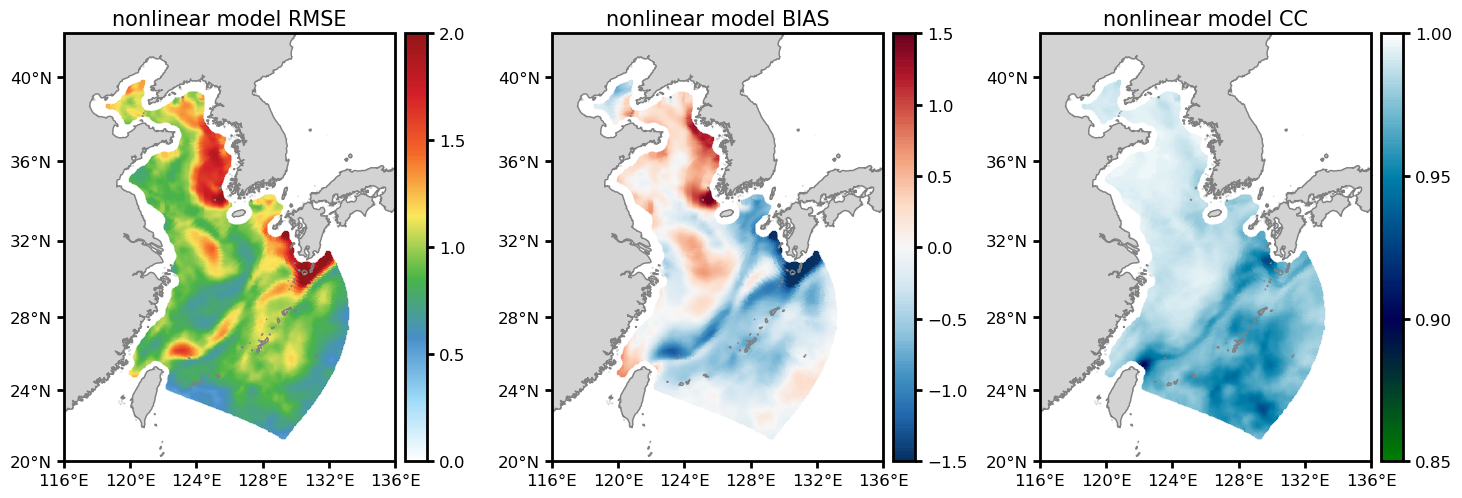

In [35]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(ncols=3, nrows=1, 
                        subplot_kw={'projection':ccrs.Mercator()},
                        figsize=(15,5)
                        
                       )

fig.tight_layout(pad=2.6)

#RMSE
set_ecs_pcolor_bg(axs[0])
axs[0].set_title('nonlinear model RMSE',fontsize=15)
sc = axs[0].scatter(ds_std.lon.data,ds_std.lat.data,
               5,
               nl_err_overall['rmse'].data,
               marker='s',
               vmin=0,vmax=2,cmap=cmaps.WhiteBlueGreenYellowRed,
               transform=ccrs.PlateCarree(),zorder=0)
ticks_pos = np.arange(0,2.5,0.5)
ax_cb = add_geo_colorbar(sc,axs[0],ticks_pos)
#BIAS
set_ecs_pcolor_bg(axs[1])
axs[1].set_title('nonlinear model BIAS',fontsize=15)
sc = axs[1].scatter(ds_std.lon.data,ds_std.lat.data,
               5,
               nl_err_overall['bias'].data,
               marker='s',
               vmin=-1.5,vmax=1.5,cmap=cmaps.MPL_RdBu_r,
               transform=ccrs.PlateCarree(),zorder=0)
ticks_pos = np.arange(-1.5,2,0.5)
ax_cb = add_geo_colorbar(sc,axs[1],ticks_pos)
#CC
set_ecs_pcolor_bg(axs[2])
axs[2].set_title('nonlinear model CC',fontsize=15)
sc = axs[2].scatter(ds_std.lon.data,ds_std.lat.data,
               5,
               nl_err_overall['cc'].data,
               marker='s',
               vmin=0.85,vmax=1,cmap=cmaps.MPL_ocean,
               transform=ccrs.PlateCarree(),zorder=0)
ticks_pos = np.arange(0.85,1.05,0.05)
ax_cb = add_geo_colorbar(sc,axs[2],ticks_pos)
# fig.colorbar(cb,ax=axs[2],shrink=0.8)
# plt.colorbar()
plt.savefig('/Volumes/LC_1/fig_thesis/nl_err_overall.png',bbox_inches='tight',dpi=400)
plt.savefig('/Volumes/LC_1/fig_thesis/nl_err_overall.pdf',bbox_inches='tight',dpi=400)

In [36]:
# calculate  overall error time serie
nl_err_timeserie = {}
nl_err_timeserie['bias'] = np.abs(ds_std['nl_data']-
                          ds_std['obs_data']).mean(dim='datum')
nl_err_timeserie['std'] = (ds_std['nl_data']-
                         ds_std['obs_data']).std(dim='datum')
nl_err_timeserie['rmse'] = np.sqrt(nl_err_timeserie['bias']**2 +
                                 nl_err_timeserie['std']**2)
# nl_errtimeserie['cc'] = xr.corr(ds_std['obs_data'],
#                                ds_std['nl_data'],dim='ocean_time')

(0.0, 2.0)

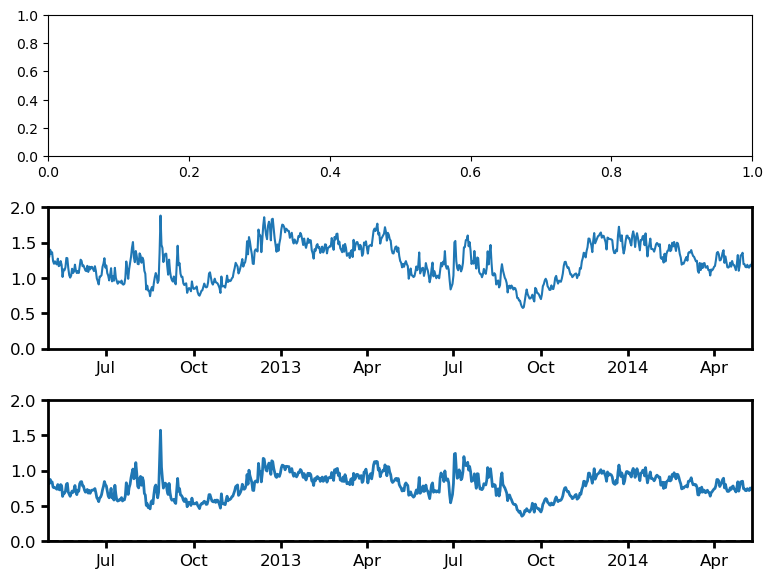

In [37]:

fig, axs = plt.subplots(3,1,figsize = (8,6))

fig.tight_layout(pad=1.6)
# axs[0].plot(ds_std.ocean_time,ds_std['obs_data'].mean(dim='datum'),color='k')
# axs[0].plot(ds_std.ocean_time,ds_std['nl_data'].mean(dim='datum'))
set_timeseries_bg(axs[1])
axs[1].plot(ds_std.ocean_time,nl_err_timeserie['rmse'])
axs[1].set_xlim([ds_std.ocean_time[0],ds_std.ocean_time[-1]])
axs[1].set_ylim([0,2])


set_timeseries_bg(axs[2])
axs[2].plot(ds_std.ocean_time,np.zeros(nl_err_timeserie['bias'].shape),'k--',linewidth=2)
axs[2].plot(ds_std.ocean_time,nl_err_timeserie['bias'],linewidth=2)
axs[2].set_xlim([ds_std.ocean_time[0],ds_std.ocean_time[-1]])
axs[2].set_ylim([0,2])


In [38]:
# yellow sea
ys_lonbry = [122,126]
ys_latbry =  [34,37]
area_range = np.where((ds_std.lon.data < ys_lonbry[-1]) 
                      & (ds_std.lon.data > ys_lonbry[0])
                      & (ds_std.lat.data > ys_latbry[0])
                      & (ds_std.lat.data < ys_latbry[-1]))
# extract yellow sea data into a  new data set 
ys_std = ds_std.isel(datum=area_range[0])
ys_std = ys_std.assign_coords(lon=lon_target[area_range[0]],lat=lat_target[area_range[0]])
# calculate AREA MEAN error timeserie
ys_err_timeserie = {}
ys_err_timeserie['bias'] = (ys_std['nl_data']-
                          ys_std['obs_data']).mean(dim='datum')
ys_err_timeserie['std'] = (ds_std['nl_data']-
                         ys_std['obs_data']).std(dim='datum')
ys_err_timeserie['rmse'] = np.sqrt(ys_err_timeserie['bias']**2 +
                                 ys_err_timeserie['std']**2)

In [39]:
ys_err_season={}
ys_err_season['bias'] = ys_err_timeserie['bias'].groupby('ocean_time.season').mean()
ys_err_season['bias']
ys_err_season['rmse'] = ys_err_timeserie['rmse'].groupby('ocean_time.season').mean()
ys_err_season['rmse']

<xarray.DataArray (season: 4)>
array([1.75574371, 1.25127538, 1.01580191, 0.88600443])
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [40]:
ys_err_timeserie['bias'].groupby('ocean_time.season').mean()

<xarray.DataArray (season: 4)>
array([ 1.52897396, -0.94277618,  0.59927295,  0.36111878])
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

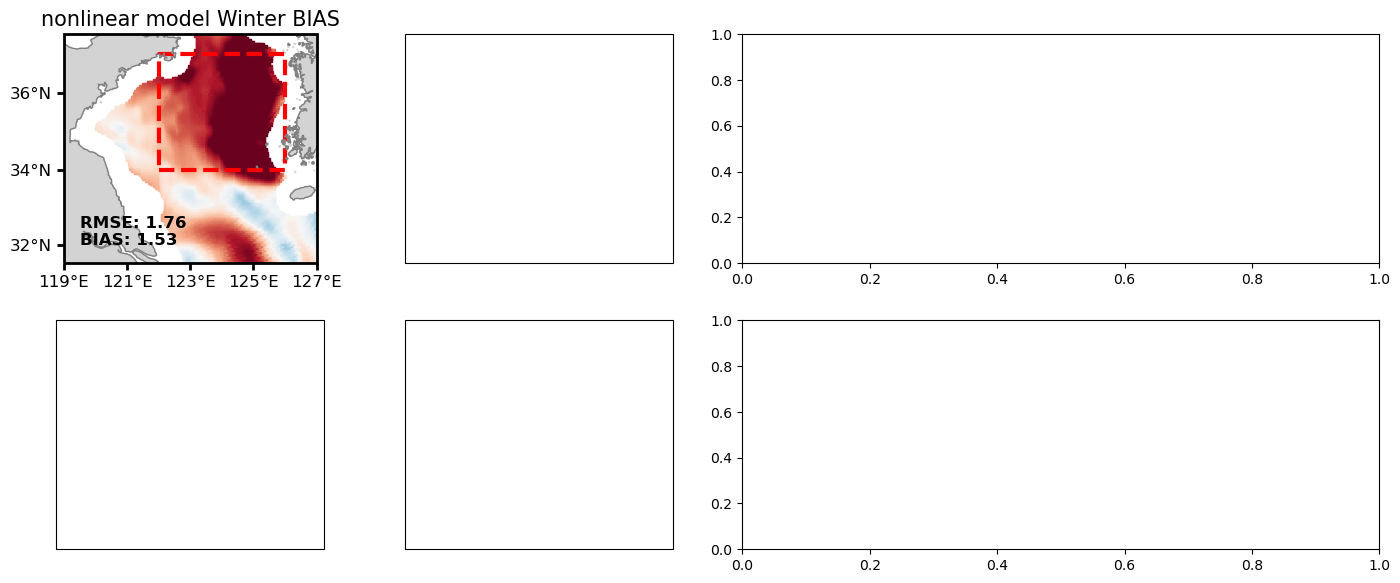

In [41]:
# plot seasonal error and area mean error timeserie
# fig, axs = plt.subplots(3,1,figsize = (6,8))

axs = []
fig = plt.figure(figsize=(14,6))
spec = fig.add_gridspec(ncols=4, nrows=2)
axs.append(fig.add_subplot(spec[0,0],projection = ccrs.Mercator())) #0
axs.append(fig.add_subplot(spec[0,1],projection = ccrs.Mercator()))  #1
axs.append(fig.add_subplot(spec[0,2:])) #2
axs.append(fig.add_subplot(spec[1,0],projection = ccrs.Mercator()))  #3
axs.append(fig.add_subplot(spec[1,1],projection = ccrs.Mercator()))  #4
axs.append(fig.add_subplot(spec[1,2:])) #5

fig.tight_layout(pad=2)

iax=0
set_ys_pcolor_bg(axs[iax])
axs[iax].set_title('nonlinear model Winter BIAS',fontsize=15)
sc = axs[iax].scatter(ds_std.lon.data,ds_std.lat.data,
               5,
               nl_error_season['bias'].sel(season='DJF').data,
               marker='s',
              vmin=-1.5,vmax=1.5,cmap=cmaps.MPL_RdBu_r,
               transform=ccrs.PlateCarree(),zorder=0)
axs[iax].text(119.5,32,
              'RMSE: %.2f\nBIAS: %.2f'%(ys_err_season['rmse'].sel(season='DJF').data,
                                        ys_err_season['bias'].sel(season='DJF').data),
              color='k',
              fontsize=12,
              fontweight='bold',
              transform=ccrs.PlateCarree(),zorder=3)
plot_sea_area_bry(ys_lonbry,ys_latbry,axs[iax])

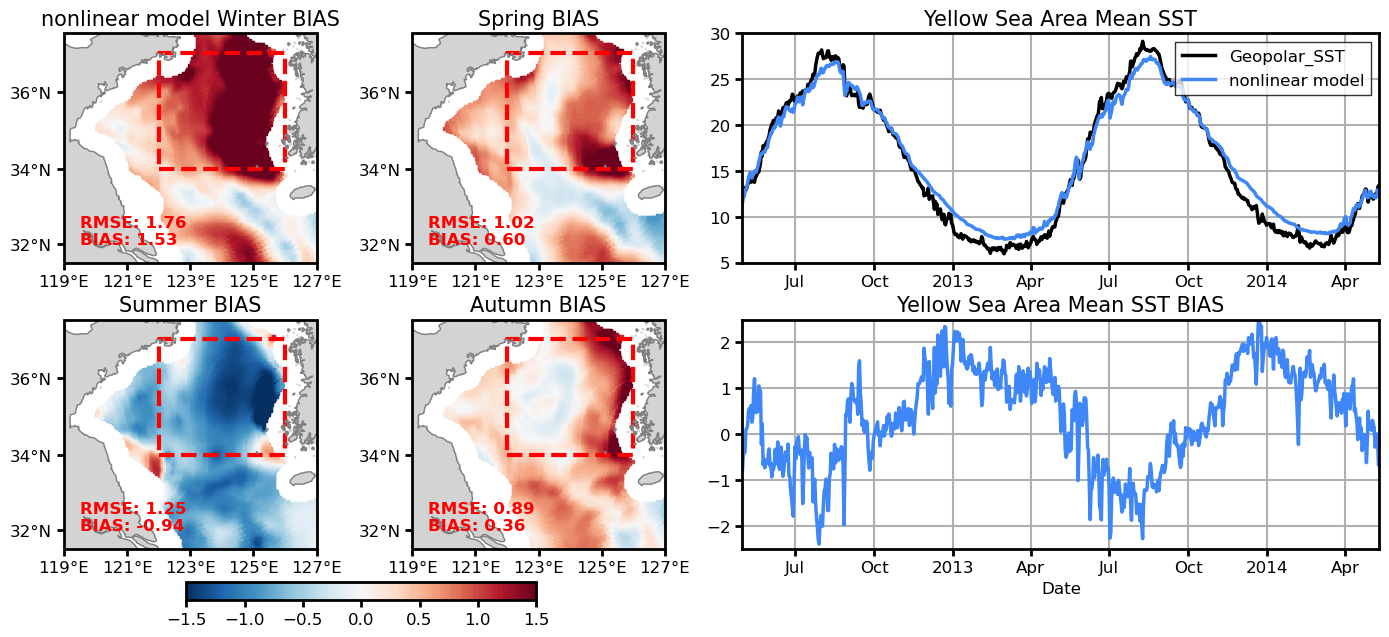

In [56]:
# plot seasonal error and area mean error timeserie
# fig, axs = plt.subplots(3,1,figsize = (6,8))

axs = []
fig = plt.figure(figsize=(14,6))
spec = fig.add_gridspec(ncols=4, nrows=2)
axs.append(fig.add_subplot(spec[0,0],projection = ccrs.Mercator())) #0
axs.append(fig.add_subplot(spec[0,1],projection = ccrs.Mercator()))  #1
axs.append(fig.add_subplot(spec[0,2:])) #2
axs.append(fig.add_subplot(spec[1,0],projection = ccrs.Mercator()))  #3
axs.append(fig.add_subplot(spec[1,1],projection = ccrs.Mercator()))  #4
axs.append(fig.add_subplot(spec[1,2:])) #5

fig.tight_layout(pad=2)

iax=0
set_ys_pcolor_bg(axs[iax])
axs[iax].set_title('nonlinear model Winter BIAS',fontsize=15)
sc = axs[iax].scatter(ds_std.lon.data,ds_std.lat.data,
               5,
               nl_error_season['bias'].sel(season='DJF').data,
               marker='s',
              vmin=-1.5,vmax=1.5,cmap=cmaps.MPL_RdBu_r,
               transform=ccrs.PlateCarree(),zorder=0)
plot_sea_area_bry(ys_lonbry,ys_latbry,axs[iax])
axs[iax].text(119.5,32,
              'RMSE: %.2f\nBIAS: %.2f'%(ys_err_season['rmse'].sel(season='DJF').data,
                                        ys_err_season['bias'].sel(season='DJF').data),
              color='r',
              fontsize=12,
              fontweight='bold',
              transform=ccrs.PlateCarree(),zorder=3)
# ticks_pos = np.arange(-1.5,2,0.5)
# ax_cb = add_geo_colorbar(sc,axs[iax],ticks_pos)  


iax=1
set_ys_pcolor_bg(axs[iax])
axs[iax].set_title('Spring BIAS',fontsize=15)
sc = axs[iax].scatter(ds_std.lon.data,ds_std.lat.data,
               5,
               nl_error_season['bias'].sel(season='MAM').data,
               marker='s',
              vmin=-1.5,vmax=1.5,cmap=cmaps.MPL_RdBu_r,
               transform=ccrs.PlateCarree(),zorder=0)
plot_sea_area_bry(ys_lonbry,ys_latbry,axs[iax])
axs[iax].text(119.5,32,
              'RMSE: %.2f\nBIAS: %.2f'%(ys_err_season['rmse'].sel(season='MAM').data,
                                        ys_err_season['bias'].sel(season='MAM').data),
              color='r',
              fontsize=12,
              fontweight='bold',
              transform=ccrs.PlateCarree(),zorder=3)
# ticks_pos = np.arange(-1.5,2,0.5)
# ax_cb = add_geo_colorbar(sc,axs[iax],ticks_pos)  

iax=2
set_timeseries_bg(axs[iax])
axs[iax].plot(ys_std.ocean_time,ys_std['obs_data'].mean(dim='datum'),
              color='k',linewidth=2.5,
              label='Geopolar_SST')
axs[iax].plot(ys_std.ocean_time,ys_std['nl_data'].mean(dim='datum'),
              color=my_palette[0],linewidth=2.5,
              label ='nonlinear model')
axs[iax].set_xlim([ys_std.ocean_time[0],ys_std.ocean_time[-1]])
# axs[0].set_xti([ys_std.ocean_time[0],ys_std.ocean_time[-1]])
axs[iax].set_ylim([5,30])
axs[iax].legend(loc='upper right',fancybox=False,fontsize = 12,edgecolor='k')
axs[iax].grid(linewidth=1.5)
axs[iax].set_title('Yellow Sea Area Mean SST',fontsize=15)

iax=3
set_ys_pcolor_bg(axs[iax])
axs[iax].set_title('Summer BIAS',fontsize=15)
sc = axs[iax].scatter(ds_std.lon.data,ds_std.lat.data,
               5,
               nl_error_season['bias'].sel(season='JJA').data,
               marker='s',
              vmin=-1.5,vmax=1.5,cmap=cmaps.MPL_RdBu_r,
               transform=ccrs.PlateCarree(),zorder=0)
plot_sea_area_bry(ys_lonbry,ys_latbry,axs[iax])
axs[iax].text(119.5,32,
              'RMSE: %.2f\nBIAS: %.2f'%(ys_err_season['rmse'].sel(season='JJA').data,
                                        ys_err_season['bias'].sel(season='JJA').data),
              color='r',
              fontsize=12,
              fontweight='bold',
              transform=ccrs.PlateCarree(),zorder=3)
# # ticks_pos = np.arange(-1.5,2,0.5)
# ax_cb = add_geo_colorbar(sc,axs[iax],ticks_pos)  

iax=4
set_ys_pcolor_bg(axs[iax])
axs[iax].set_title('Autumn BIAS',fontsize=15)
sc = axs[iax].scatter(ds_std.lon.data,ds_std.lat.data,
               5,
               nl_error_season['bias'].sel(season='SON').data,
               marker='s',
              vmin=-1.5,vmax=1.5,cmap=cmaps.MPL_RdBu_r,
               transform=ccrs.PlateCarree(),zorder=0)
plot_sea_area_bry(ys_lonbry,ys_latbry,axs[iax])
axs[iax].text(119.5,32,
              'RMSE: %.2f\nBIAS: %.2f'%(ys_err_season['rmse'].sel(season='SON').data,
                                        ys_err_season['bias'].sel(season='SON').data),
              color='r',
              fontsize=12,
              fontweight='bold',
              transform=ccrs.PlateCarree(),zorder=3)
# ticks_pos = np.arange(-1,2,1)
# ax_cb = add_geo_colorbar(sc,axs[iax],ticks_pos)  
position=fig.add_axes([ 0.12, 0,0.25, 0.03, ])

cb = fig.colorbar(sc, cax = position,orientation='horizontal',
                  ticks = np.arange(-1.5,2,0.5))
for bnd in position.spines.keys():
    position.spines[bnd].set_linewidth('2')
position.tick_params(direction = 'out', length =5, width = 2, labelsize = 12)
# cb.set_label('$\degree$C') 

iax=5
set_timeseries_bg(axs[iax])
# axs[2].plot(ys_std.ocean_time,np.zeros(ys_err_timeserie['bias'].shape),'k--',linewidth=2)
axs[iax].plot(ys_std.ocean_time,ys_err_timeserie['bias'],
              color=my_palette[0],
              linewidth=2.5)
axs[iax].set_xlim([ys_std.ocean_time[0],ys_std.ocean_time[-1]])
axs[iax].set_ylim([-2.5,2.5])
axs[iax].set_xlabel('Date',fontsize=12)
axs[iax].grid(linewidth=1.5)
axs[iax].set_title('Yellow Sea Area Mean SST BIAS',fontsize=15)

plt.savefig('/Volumes/LC_1/fig_thesis/ys_err_timeserie.png',bbox_inches='tight',dpi=400)
plt.savefig('/Volumes/LC_1/fig_thesis/ys_err_timeserie.pdf',bbox_inches='tight',dpi=400)

In [44]:
# bohai sea
bh_lonbry = [117,123]
bh_latbry =  [37,41]
bh_Ybox = np.array([bh_latbry[0],bh_latbry[0],         39.5,bh_latbry[-1],bh_latbry[-1],bh_latbry[0]])
bh_Xbox = np.array([bh_lonbry[0],        119.,bh_lonbry[-1],bh_lonbry[-1], bh_lonbry[0],bh_lonbry[0]])

area_range = np.where(get_index_in_area(ds_std.lon.data,ds_std.lat.data,bh_Xbox,bh_Ybox))
# area_range = np.where((ds_std.lon.data < bh_lonbry[-1]) 
#                       & (ds_std.lon.data > bh_lonbry[0])
#                       & (ds_std.lat.data > bh_latbry[0])
#                       & (ds_std.lat.data < bh_latbry[-1]))
# extract yellow sea data into a  new data set 
bh_std = ds_std.isel(datum=area_range[0])
bh_std = bh_std.assign_coords(lon=lon_target[area_range[0]],lat=lat_target[area_range[0]])
# calculate AREA MEAN error timeserie
bh_err_timeserie = {}
bh_err_timeserie['bias'] = (bh_std['nl_data']-
                          bh_std['obs_data']).mean(dim='datum')
bh_err_timeserie['std'] = (ds_std['nl_data']-
                         bh_std['obs_data']).std(dim='datum')
bh_err_timeserie['rmse'] = np.sqrt(bh_err_timeserie['bias']**2 +
                                 bh_err_timeserie['std']**2)

In [45]:
bh_err_season={}
bh_err_season['bias'] = bh_err_timeserie['bias'].groupby('ocean_time.season').mean()
bh_err_season['bias']
bh_err_season['rmse'] = bh_err_timeserie['rmse'].groupby('ocean_time.season').mean()
bh_err_season['rmse']

<xarray.DataArray (season: 4)>
array([0.88995788, 1.20842542, 0.99999776, 0.78134713])
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

Text(117.0, 35.8, 'RMSE: 0.89\nBIAS: -0.56')

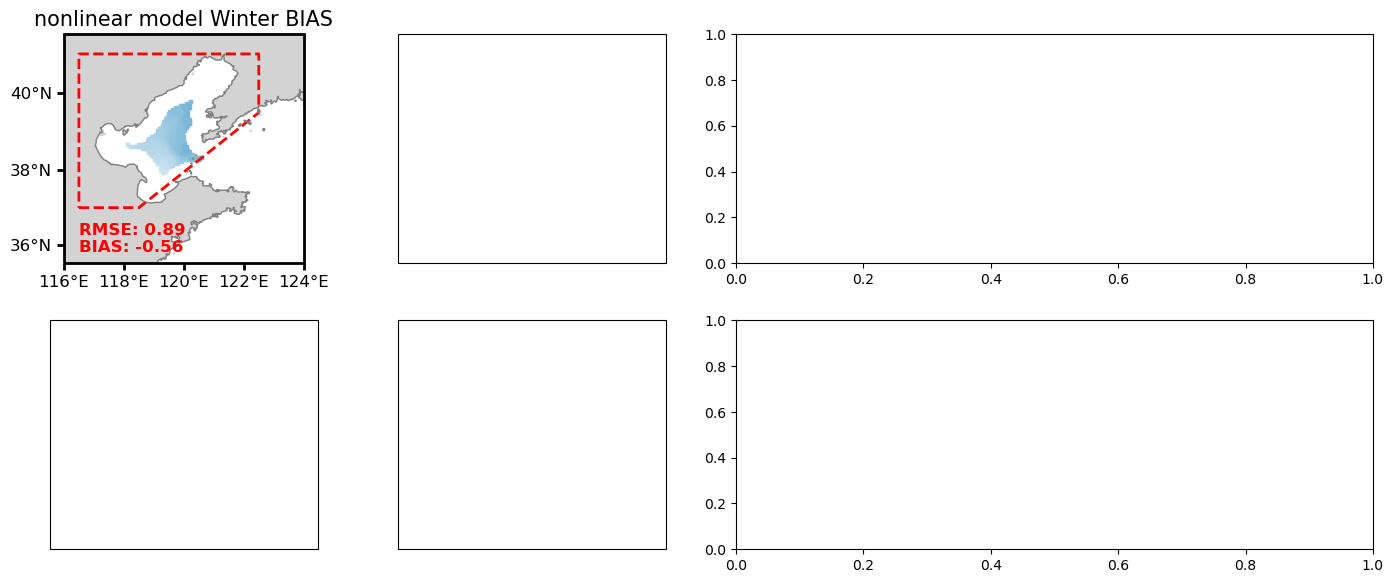

In [47]:
axs = []
fig = plt.figure(figsize=(14,6))
spec = fig.add_gridspec(ncols=4, nrows=2)
axs.append(fig.add_subplot(spec[0,0],projection = ccrs.Mercator())) #0
axs.append(fig.add_subplot(spec[0,1],projection = ccrs.Mercator()))  #1
axs.append(fig.add_subplot(spec[0,2:])) #2
axs.append(fig.add_subplot(spec[1,0],projection = ccrs.Mercator()))  #3
axs.append(fig.add_subplot(spec[1,1],projection = ccrs.Mercator()))  #4
axs.append(fig.add_subplot(spec[1,2:])) #5

fig.tight_layout(pad=2)

iax=0
set_bh_pcolor_bg(axs[iax])
axs[iax].set_title('nonlinear model Winter BIAS',fontsize=15)
sc = axs[iax].scatter(bh_std.lon.data,bh_std.lat.data,
               5,
               bh_std['nl_data'].isel(ocean_time=0).data,
               marker='s',
              vmin=-0,vmax=30,cmap=cmaps.MPL_RdBu_r,
               transform=ccrs.PlateCarree(),zorder=0)
axs[iax].plot(bh_Xbox,bh_Ybox,'r--',linewidth=2,transform=ccrs.PlateCarree(),zorder=2)
axs[iax].text(117.,35.8,
              'RMSE: %.2f\nBIAS: %.2f'%(bh_err_season['rmse'].sel(season='DJF').data,
                                        bh_err_season['bias'].sel(season='DJF').data),
              color='r',
              fontsize=12,
              fontweight='bold',
              transform=ccrs.PlateCarree(),zorder=3)


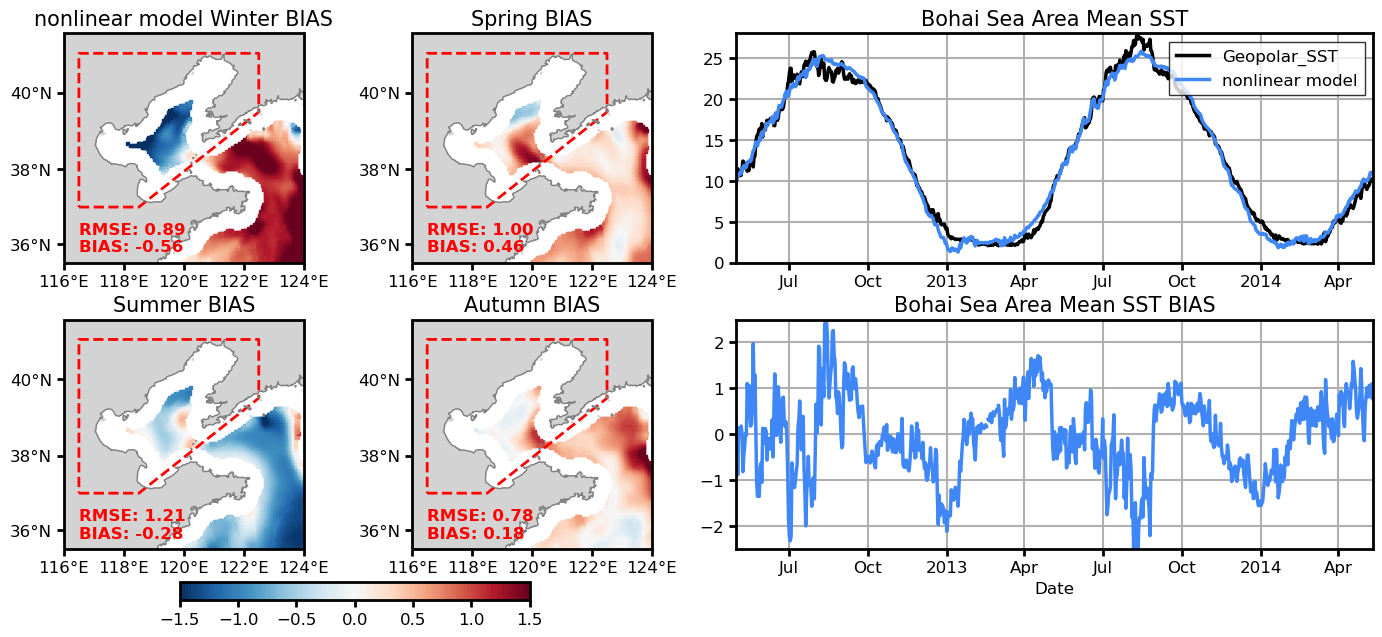

In [59]:
# plot seasonal error and area mean error timeserie
# fig, axs = plt.subplots(3,1,figsize = (6,8))

axs = []
fig = plt.figure(figsize=(14,6))
spec = fig.add_gridspec(ncols=4, nrows=2)
axs.append(fig.add_subplot(spec[0,0],projection = ccrs.Mercator())) #0
axs.append(fig.add_subplot(spec[0,1],projection = ccrs.Mercator()))  #1
axs.append(fig.add_subplot(spec[0,2:])) #2
axs.append(fig.add_subplot(spec[1,0],projection = ccrs.Mercator()))  #3
axs.append(fig.add_subplot(spec[1,1],projection = ccrs.Mercator()))  #4
axs.append(fig.add_subplot(spec[1,2:])) #5

fig.tight_layout(pad=2)

iax=0
set_bh_pcolor_bg(axs[iax])
axs[iax].set_title('nonlinear model Winter BIAS',fontsize=15)
sc = axs[iax].scatter(ds_std.lon.data,ds_std.lat.data,
               5,
               nl_error_season['bias'].sel(season='DJF').data,
               marker='s',
              vmin=-1.5,vmax=1.5,cmap=cmaps.MPL_RdBu_r,
               transform=ccrs.PlateCarree(),zorder=0)
axs[iax].plot(bh_Xbox,bh_Ybox,'r--',linewidth=2,transform=ccrs.PlateCarree(),zorder=2)
axs[iax].text(117.,35.8,
              'RMSE: %.2f\nBIAS: %.2f'%(bh_err_season['rmse'].sel(season='DJF').data,
                                        bh_err_season['bias'].sel(season='DJF').data),
              color='r',
              fontsize=12,
              fontweight='bold',
              transform=ccrs.PlateCarree(),zorder=3)

# ticks_pos = np.arange(-1.5,2,0.5)
# ax_cb = add_geo_colorbar(sc,axs[iax],ticks_pos)  


iax=1
set_bh_pcolor_bg(axs[iax])
axs[iax].set_title('Spring BIAS',fontsize=15)
sc = axs[iax].scatter(ds_std.lon.data,ds_std.lat.data,
               5,
               nl_error_season['bias'].sel(season='MAM').data,
               marker='s',
              vmin=-1.5,vmax=1.5,cmap=cmaps.MPL_RdBu_r,
               transform=ccrs.PlateCarree(),zorder=0)
axs[iax].plot(bh_Xbox,bh_Ybox,'r--',linewidth=2,transform=ccrs.PlateCarree(),zorder=2)
axs[iax].text(117.,35.8,
              'RMSE: %.2f\nBIAS: %.2f'%(bh_err_season['rmse'].sel(season='MAM').data,
                                        bh_err_season['bias'].sel(season='MAM').data),
              color='r',
              fontsize=12,
              fontweight='bold',
              transform=ccrs.PlateCarree(),zorder=3)

# ticks_pos = np.arange(-1.5,2,0.5)
# ax_cb = add_geo_colorbar(sc,axs[iax],ticks_pos)  

iax=2
set_timeseries_bg(axs[iax])
axs[iax].plot(bh_std.ocean_time,bh_std['obs_data'].mean(dim='datum'),
              color='k',linewidth=2.5,
              label='Geopolar_SST')
axs[iax].plot(bh_std.ocean_time,bh_std['nl_data'].mean(dim='datum'),
              color=my_palette[0],linewidth=2.5,
              label ='nonlinear model')
axs[iax].set_xlim([bh_std.ocean_time[0],bh_std.ocean_time[-1]])
# axs[0].set_xti([bh_std.ocean_time[0],bh_std.ocean_time[-1]])
axs[iax].set_ylim([0,28])
axs[iax].legend(loc='upper right',fancybox=False,fontsize = 12,edgecolor='k')
axs[iax].grid(linewidth=1.5)
axs[iax].set_title('Bohai Sea Area Mean SST',fontsize=15)

iax=3
set_bh_pcolor_bg(axs[iax])
axs[iax].set_title('Summer BIAS',fontsize=15)
sc = axs[iax].scatter(ds_std.lon.data,ds_std.lat.data,
               5,
               nl_error_season['bias'].sel(season='JJA').data,
               marker='s',
              vmin=-1.5,vmax=1.5,cmap=cmaps.MPL_RdBu_r,
               transform=ccrs.PlateCarree(),zorder=0)
axs[iax].plot(bh_Xbox,bh_Ybox,'r--',linewidth=2,transform=ccrs.PlateCarree(),zorder=2)
axs[iax].text(117.,35.8,
              'RMSE: %.2f\nBIAS: %.2f'%(bh_err_season['rmse'].sel(season='JJA').data,
                                        bh_err_season['bias'].sel(season='JJA').data),
              color='r',
              fontsize=12,
              fontweight='bold',
              transform=ccrs.PlateCarree(),zorder=3)

# # ticks_pos = np.arange(-1.5,2,0.5)
# ax_cb = add_geo_colorbar(sc,axs[iax],ticks_pos)  

iax=4
set_bh_pcolor_bg(axs[iax])
axs[iax].set_title('Autumn BIAS',fontsize=15)
sc = axs[iax].scatter(ds_std.lon.data,ds_std.lat.data,
               5,
               nl_error_season['bias'].sel(season='SON').data,
               marker='s',
              vmin=-1.5,vmax=1.5,cmap=cmaps.MPL_RdBu_r,
               transform=ccrs.PlateCarree(),zorder=0)
axs[iax].plot(bh_Xbox,bh_Ybox,'r--',linewidth=2,transform=ccrs.PlateCarree(),zorder=2)
axs[iax].text(117.,35.8,
              'RMSE: %.2f\nBIAS: %.2f'%(bh_err_season['rmse'].sel(season='SON').data,
                                        bh_err_season['bias'].sel(season='SON').data),
              color='r',
              fontsize=12,
              fontweight='bold',
              transform=ccrs.PlateCarree(),zorder=3)

# ticks_pos = np.arange(-1,2,1)
# ax_cb = add_geo_colorbar(sc,axs[iax],ticks_pos)  
position=fig.add_axes([ 0.12, 0,0.25, 0.03, ])

cb = fig.colorbar(sc, cax = position,orientation='horizontal',
                  ticks = np.arange(-1.5,2,0.5))
for bnd in position.spines.keys():
    position.spines[bnd].set_linewidth('2')
position.tick_params(direction = 'out', length =5, width = 2, labelsize = 12)
# cb.set_label('$\degree$C') 

iax=5
set_timeseries_bg(axs[iax])
# axs[2].plot(bh_std.ocean_time,np.zeros(bh_err_timeserie['bias'].shape),'k--',linewidth=2)
axs[iax].plot(bh_std.ocean_time,bh_err_timeserie['bias'],
              color=my_palette[0],
              linewidth=2.5)
axs[iax].set_xlim([bh_std.ocean_time[0],bh_std.ocean_time[-1]])
axs[iax].set_ylim([-2.5,2.5])
axs[iax].set_xlabel('Date',fontsize=12)
axs[iax].grid(linewidth=1.5)
axs[iax].set_title('Bohai Sea Area Mean SST BIAS',fontsize=15)

plt.savefig('/Volumes/LC_1/fig_thesis/bh_err_timeserie.png',bbox_inches='tight',dpi=400)
plt.savefig('/Volumes/LC_1/fig_thesis/bh_err_timeserie.pdf',bbox_inches='tight',dpi=400)

In [49]:
# chang jiang river estuary
cre_lonbry = [122,126.5]
cre_latbry =  [29,33]
area_range = np.where((ds_std.lon.data < cre_lonbry[-1]) 
                      & (ds_std.lon.data > cre_lonbry[0])
                      & (ds_std.lat.data > cre_latbry[0])
                      & (ds_std.lat.data < cre_latbry[-1]))
# extract yellow sea data into a  new data set 
cre_std = ds_std.isel(datum=area_range[0])
cre_std = cre_std.assign_coords(lon=lon_target[area_range[0]],lat=lat_target[area_range[0]])
# calculate AREA MEAN error timeserie
cre_err_timeserie = {}
cre_err_timeserie['bias'] = (cre_std['nl_data']-
                          cre_std['obs_data']).mean(dim='datum')
cre_err_timeserie['std'] = (ds_std['nl_data']-
                         cre_std['obs_data']).std(dim='datum')
cre_err_timeserie['rmse'] = np.sqrt(cre_err_timeserie['bias']**2 +
                                 cre_err_timeserie['std']**2)

In [51]:
cre_err_season={}
cre_err_season['bias'] = cre_err_timeserie['bias'].groupby('ocean_time.season').mean()
cre_err_season['bias']
cre_err_season['rmse'] = cre_err_timeserie['rmse'].groupby('ocean_time.season').mean()
cre_err_season['rmse']

<xarray.DataArray (season: 4)>
array([0.89393845, 1.08000861, 1.01043172, 0.7130106 ])
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

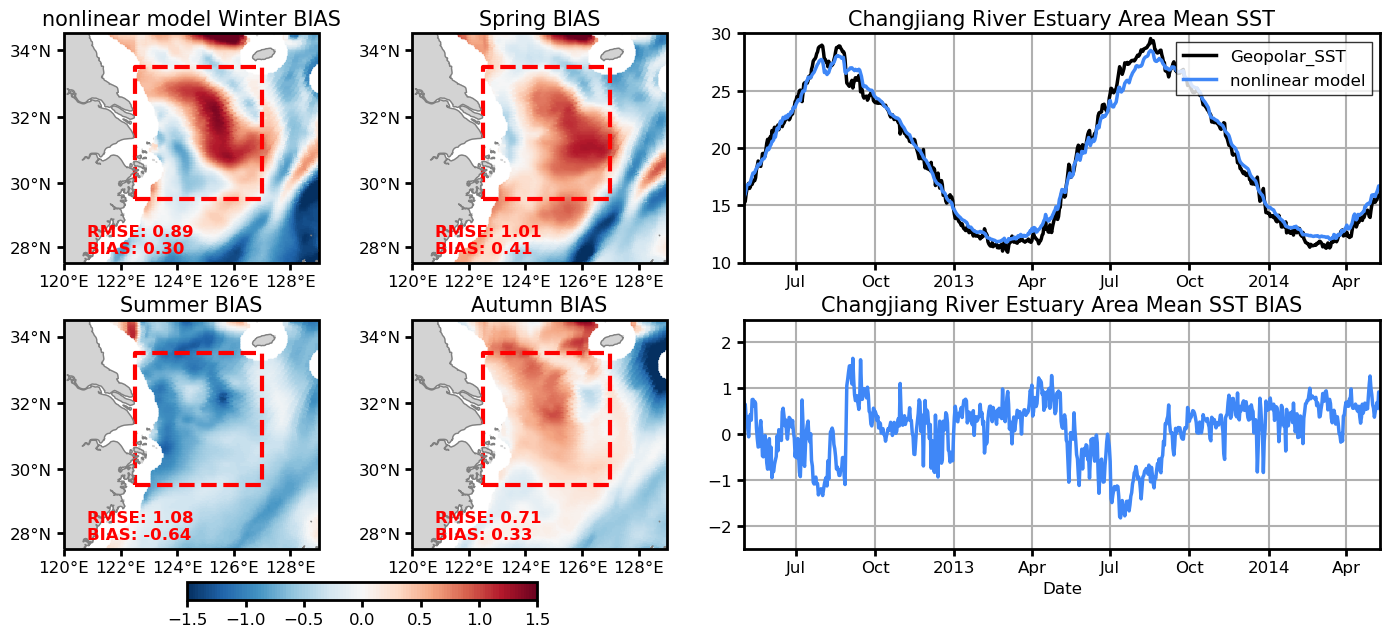

In [58]:
# plot seasonal error and area mean error timeserie
# fig, axs = plt.subplots(3,1,figsize = (6,8))

axs = []
fig = plt.figure(figsize=(14,6))
spec = fig.add_gridspec(ncols=4, nrows=2)
axs.append(fig.add_subplot(spec[0,0],projection = ccrs.Mercator())) #0
axs.append(fig.add_subplot(spec[0,1],projection = ccrs.Mercator()))  #1
axs.append(fig.add_subplot(spec[0,2:])) #2
axs.append(fig.add_subplot(spec[1,0],projection = ccrs.Mercator()))  #3
axs.append(fig.add_subplot(spec[1,1],projection = ccrs.Mercator()))  #4
axs.append(fig.add_subplot(spec[1,2:])) #5

fig.tight_layout(pad=2)

iax=0
set_cre_pcolor_bg(axs[iax])
axs[iax].set_title('nonlinear model Winter BIAS',fontsize=15)
sc = axs[iax].scatter(ds_std.lon.data,ds_std.lat.data,
               5,
               nl_error_season['bias'].sel(season='DJF').data,
               marker='s',
              vmin=-1.5,vmax=1.5,cmap=cmaps.MPL_RdBu_r,
               transform=ccrs.PlateCarree(),zorder=0)
plot_sea_area_bry(cre_lonbry,cre_latbry,axs[iax])
axs[iax].text(120.3,27.3,
              'RMSE: %.2f\nBIAS: %.2f'%(cre_err_season['rmse'].sel(season='DJF').data,
                                        cre_err_season['bias'].sel(season='DJF').data),
              color='r',
              fontsize=12,
              fontweight='bold',
              transform=ccrs.PlateCarree(),zorder=3)
# ticks_pos = np.arange(-1.5,2,0.5)
# ax_cb = add_geo_colorbar(sc,axs[iax],ticks_pos)  


iax=1
set_cre_pcolor_bg(axs[iax])
axs[iax].set_title('Spring BIAS',fontsize=15)
sc = axs[iax].scatter(ds_std.lon.data,ds_std.lat.data,
               5,
               nl_error_season['bias'].sel(season='MAM').data,
               marker='s',
              vmin=-1.5,vmax=1.5,cmap=cmaps.MPL_RdBu_r,
               transform=ccrs.PlateCarree(),zorder=0)
plot_sea_area_bry(cre_lonbry,cre_latbry,axs[iax])
axs[iax].text(120.3,27.3,
              'RMSE: %.2f\nBIAS: %.2f'%(cre_err_season['rmse'].sel(season='MAM').data,
                                        cre_err_season['bias'].sel(season='MAM').data),
              color='r',
              fontsize=12,
              fontweight='bold',
              transform=ccrs.PlateCarree(),zorder=3)
# ticks_pos = np.arange(-1.5,2,0.5)
# ax_cb = add_geo_colorbar(sc,axs[iax],ticks_pos)  

iax=2
set_timeseries_bg(axs[iax])
axs[iax].plot(cre_std.ocean_time,cre_std['obs_data'].mean(dim='datum'),
              color='k',linewidth=2.5,
              label='Geopolar_SST')
axs[iax].plot(cre_std.ocean_time,cre_std['nl_data'].mean(dim='datum'),
              color=my_palette[0],linewidth=2.5,
              label ='nonlinear model')
axs[iax].set_xlim([cre_std.ocean_time[0],cre_std.ocean_time[-1]])
# axs[0].set_xti([cre_std.ocean_time[0],cre_std.ocean_time[-1]])
axs[iax].set_ylim([10,30])
axs[iax].legend(loc='upper right',fancybox=False,fontsize = 12,edgecolor='k')
axs[iax].grid(linewidth=1.5)
axs[iax].set_title('Changjiang River Estuary Area Mean SST',fontsize=15)

iax=3
set_cre_pcolor_bg(axs[iax])
axs[iax].set_title('Summer BIAS',fontsize=15)
sc = axs[iax].scatter(ds_std.lon.data,ds_std.lat.data,
               5,
               nl_error_season['bias'].sel(season='JJA').data,
               marker='s',
              vmin=-1.5,vmax=1.5,cmap=cmaps.MPL_RdBu_r,
               transform=ccrs.PlateCarree(),zorder=0)
plot_sea_area_bry(cre_lonbry,cre_latbry,axs[iax])
axs[iax].text(120.3,27.3,
              'RMSE: %.2f\nBIAS: %.2f'%(cre_err_season['rmse'].sel(season='JJA').data,
                                        cre_err_season['bias'].sel(season='JJA').data),
              color='r',
              fontsize=12,
              fontweight='bold',
              transform=ccrs.PlateCarree(),zorder=3)
# # ticks_pos = np.arange(-1.5,2,0.5)
# ax_cb = add_geo_colorbar(sc,axs[iax],ticks_pos)  

iax=4
set_cre_pcolor_bg(axs[iax])
axs[iax].set_title('Autumn BIAS',fontsize=15)
sc = axs[iax].scatter(ds_std.lon.data,ds_std.lat.data,
               5,
               nl_error_season['bias'].sel(season='SON').data,
               marker='s',
              vmin=-1.5,vmax=1.5,cmap=cmaps.MPL_RdBu_r,
               transform=ccrs.PlateCarree(),zorder=0)
plot_sea_area_bry(cre_lonbry,cre_latbry,axs[iax])
axs[iax].text(120.3,27.3,
              'RMSE: %.2f\nBIAS: %.2f'%(cre_err_season['rmse'].sel(season='SON').data,
                                        cre_err_season['bias'].sel(season='SON').data),
              color='r',
              fontsize=12,
              fontweight='bold',
              transform=ccrs.PlateCarree(),zorder=3)
# ticks_pos = np.arange(-1,2,1)
# ax_cb = add_geo_colorbar(sc,axs[iax],ticks_pos)  
position=fig.add_axes([ 0.12, 0,0.25, 0.03, ])

cb = fig.colorbar(sc, cax = position,orientation='horizontal',
                  ticks = np.arange(-1.5,2,0.5))
for bnd in position.spines.keys():
    position.spines[bnd].set_linewidth('2')
position.tick_params(direction = 'out', length =5, width = 2, labelsize = 12)
# cb.set_label('$\degree$C') 

iax=5
set_timeseries_bg(axs[iax])
# axs[2].plot(cre_std.ocean_time,np.zeros(cre_err_timeserie['bias'].shape),'k--',linewidth=2)
axs[iax].plot(cre_std.ocean_time,cre_err_timeserie['bias'],
              color=my_palette[0],
              linewidth=2.5)
axs[iax].set_xlim([cre_std.ocean_time[0],cre_std.ocean_time[-1]])
axs[iax].set_ylim([-2.5,2.5])
axs[iax].set_xlabel('Date',fontsize=12)
axs[iax].grid(linewidth=1.5)
axs[iax].set_title('Changjiang River Estuary Area Mean SST BIAS',fontsize=15)

plt.savefig('/Volumes/LC_1/fig_thesis/cre_err_timeserie.png',bbox_inches='tight',dpi=400)
plt.savefig('/Volumes/LC_1/fig_thesis/cre_err_timeserie.pdf',bbox_inches='tight',dpi=400)

In [65]:
cre_err_timeserie['bias'].min()

<xarray.DataArray ()>
array(-1.82821137)

In [66]:
cre_err_timeserie['bias'].ocean_time[438]

<xarray.DataArray 'ocean_time' ()>
array('2013-07-13T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    ocean_time  datetime64[ns] 2013-07-13